# Pathological Voices Detection

## Libraries

In [25]:
import warnings
warnings.filterwarnings('ignore')
import os
import glob
from tqdm import tqdm
from PIL import Image
import pandas as pd
import numpy as np
#from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pyts.image import GramianAngularField
import cv2

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, StratifiedKFold
from sklearn.svm import SVC

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict

from joblib import dump

## Example

Here, we upload and plot a single voice signal from the ".txt" file of subject 1:

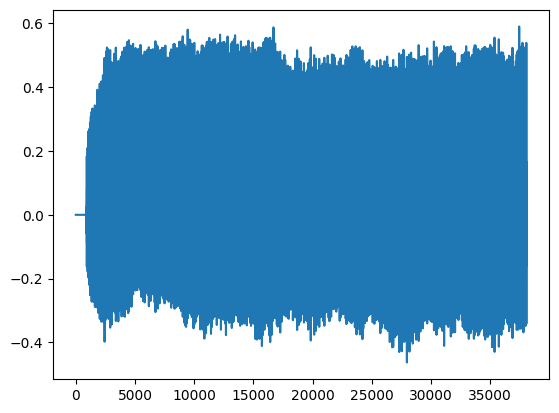

In [86]:
df1 = pd.read_csv("C:/Users/aless/Desktop/opencv competition/VOICED DATASET/voice001.txt",  delimiter='\t')
plt.plot(df1)
plt.show()

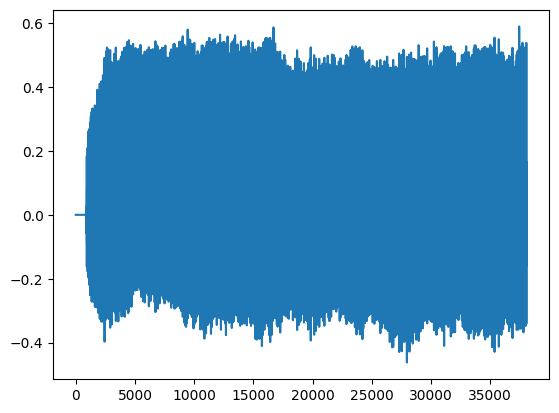

In [87]:
signal1 = df1.values
scaler = StandardScaler(with_std=False)
scaled = scaler.fit_transform(signal1)
plt.plot(scaled)
plt.show()

In [10]:
dump(scaler, 'C:/Users/aless/Desktop/opencv competition/scaler.joblib') 

['C:/Users/aless/Desktop/opencv competition/scaler.joblib']

In order to plot the resulting gray image, the function need that the array is of shape (H x W x C). But first, image should be standardized to be integer pixels in range [0, 255].

(1, 128, 128)


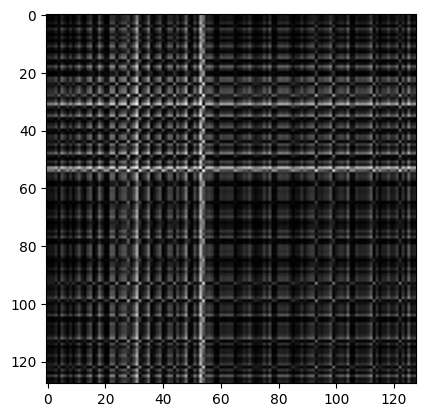

In [99]:
signal2 = np.transpose(signal1)
gasf = GramianAngularField(method='summation', image_size=128)
img = gasf.transform(signal2)
print(img.shape)

min_val = np.min(img)
max_val = np.max(img)
img = 255 * ((img - min_val) / (max_val - min_val))
img = img.astype(np.uint8)

img = img.transpose(1,2,0)
plt.imshow(img, cmap='gray')
plt.show()

The HOG features are extracted from a 128 x 128 version on the whole image, with 4 pixels for each cell and 64 cell for each block which goes throw the image block by block (stride of size 1) and 18 bins for the final histogram.

In [103]:
#image = cv2.resize(img, (128, 128))
win_size = (128, 128)
cell_size = (8, 8)
block_size = (16, 16)
block_stride = (8, 8)
num_bins = 9
hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, num_bins)
features = hog.compute(img)
print(features.shape)

(8100,)


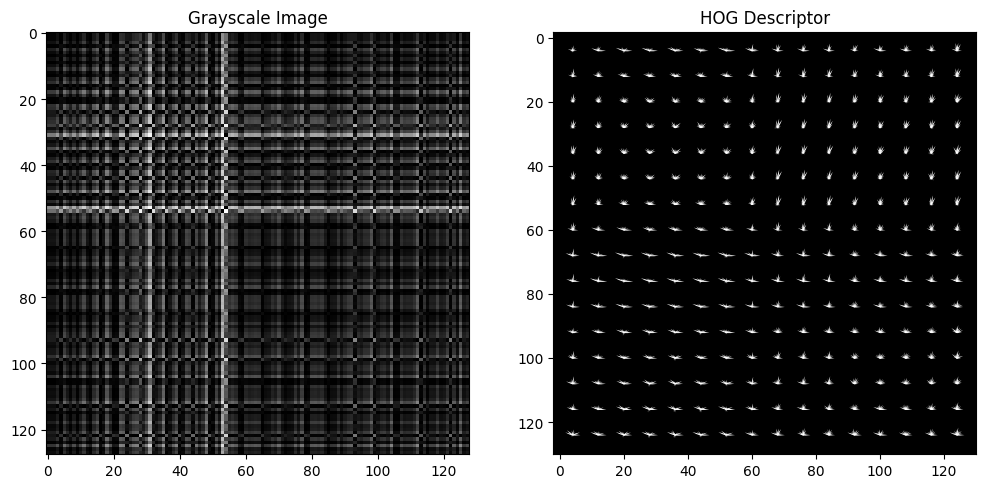

In [105]:
# Reshape the feature vector to [number of blocks in x and y direction, number of cells per block in x and y direction, number of bins]
# This will be useful later when we plot the feature vector, so that the feature vector indexing matches the image indexing
hog_descriptor_reshaped = features.reshape(15,
                                                 15,
                                                 2,
                                                 2,
                                                 9).transpose((1, 0, 2, 3, 4))

# Create an array that will hold the average gradients for each cell
ave_grad = np.zeros((16, 16, 9))

# Create an array that will count the number of histograms per cell
hist_counter = np.zeros((16, 16, 1))

# Add up all the histograms for each cell and count the number of histograms per cell
for i in range(2):
    for j in range(2):
        ave_grad[i:15 + i,
                 j:15 + j] += hog_descriptor_reshaped[:, :, i, j, :]

        hist_counter[i:15 + i,
                     j:15 + j] += 1

# Calculate the average gradient for each cell
ave_grad /= hist_counter

# Calculate the total number of vectors we have in all the cells.
len_vecs = ave_grad.shape[0] * ave_grad.shape[1] * ave_grad.shape[2]

# Create an array that has num_bins equally spaced between 0 and 180 degress in radians.
deg = np.linspace(0, np.pi, num_bins, endpoint=False)

# Each cell will have a histogram with num_bins. For each cell, plot each bin as a vector (with its magnitude
# equal to the height of the bin in the histogram, and its angle corresponding to the bin in the histogram).
# To do this, create rank 1 arrays that will hold the (x,y)-coordinate of all the vectors in all the cells in the
# image. Also, create the rank 1 arrays that will hold all the (U,V)-components of all the vectors in all the
# cells in the image. Create the arrays that will hold all the vector positons and components.
U = np.zeros((len_vecs))
V = np.zeros((len_vecs))
X = np.zeros((len_vecs))
Y = np.zeros((len_vecs))

# Set the counter to zero
counter = 0

# Use the cosine and sine functions to calculate the vector components (U,V) from their maginitudes. Remember the
# cosine and sine functions take angles in radians. Calculate the vector positions and magnitudes from the
# average gradient array
for i in range(ave_grad.shape[0]):
    for j in range(ave_grad.shape[1]):
        for k in range(ave_grad.shape[2]):
            U[counter] = ave_grad[i, j, k] * np.cos(deg[k])
            V[counter] = ave_grad[i, j, k] * np.sin(deg[k])

            X[counter] = (cell_size[0] / 2) + (cell_size[0] * i)
            Y[counter] = (cell_size[1] / 2) + (cell_size[1] * j)

            counter = counter + 1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Display the image
ax1.set(title='Grayscale Image')
ax1.imshow(img, cmap='gray')

# Plot the feature vector (HOG Descriptor)
ax2.set(title='HOG Descriptor')
ax2.quiver(Y, X, U, V, color='white', headwidth=0, headlength=0, scale_units='inches', scale=3)
ax2.invert_yaxis()
ax2.set_aspect(aspect=1)
ax2.set_facecolor('black')

Right image represents the original GASF image of subject 1, left image represents the HOG features: the higher the most important. From the HOG image it's possible to detect some circle pattern highlighting the most important part of the image. 

## Saving Gramian Angular Field Images

In this part of the code I extract the signal from a folder, apply GAF function and save images into another folder divided by labels.

In [14]:
source_folder = "C:/Users/aless/Desktop/opencv competition/VOICED DATASET"
target_folder = "C:/Users/aless/Desktop/opencv competition/imgs"

# Create the target folder if it doesn't exist
os.makedirs(target_folder, exist_ok=True)

# List all files in the source folder
file_list = os.listdir(source_folder)

In [15]:
for filename in tqdm(file_list, desc="Processing files"):
    if filename.endswith('.txt'):
        # Read the data from the file
        file_path = os.path.join(source_folder, filename)
        data = pd.read_csv(file_path,  delimiter='\t')

        array = data.values
        array = np.transpose(array)
        
        gasf = GramianAngularField(method='summation', image_size=128)
        img = gasf.transform(array)
        
        # Save the produced image in the target folder as jpg
        target_path = os.path.join(target_folder, filename.replace('.txt', '.jpg'))

        # Convert numpy array to PIL Image and save as jpg
        img = img.reshape((128, 128))  # Reshape to (128 x 128)
        img = (img - img.min()) / (img.max() - img.min()) * 255 #ensure range [0, 255]
        img = img.astype(np.uint8)
        pil_img = Image.fromarray(img, mode='L')  # 'L' mode for grayscale
        pil_img.save(target_path)

Processing files: 100%|██████████| 208/208 [00:11<00:00, 18.35it/s]


## Preprocessing

In [16]:
print('Folders inside the main directory: ', os.listdir("C:\\Users\\aless\\Desktop\\opencv competition\\imgs"))

Folders inside the main directory:  ['healthy', 'pathological']


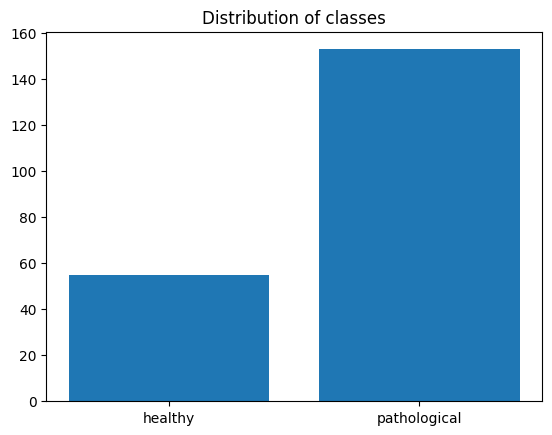

In [17]:
classes = os.listdir("C:\\Users\\aless\\Desktop\\opencv competition\\imgs")
sum_images = []
for i in classes:
    img_base_path = "C:\\Users\\aless\\Desktop\\opencv competition\\imgs/" + str(i)
    images = os.listdir(img_base_path)
    sum_images.append(len(images))
plt.bar(classes, sum_images)
plt.title('Distribution of classes')
plt.show()

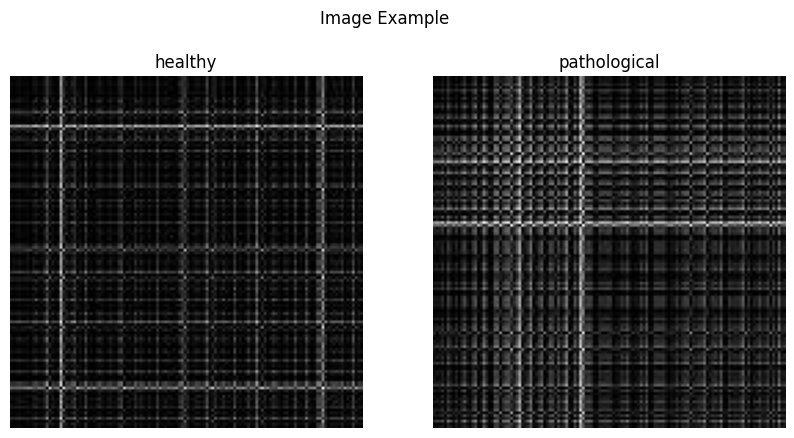

In [18]:
images = []
paths = []

fig,ax = plt.subplots(1,2,figsize = (10, 5))
ax = ax.ravel()

for idx, i in enumerate(classes):
    img_base_path = "C:\\Users\\aless\\Desktop\\opencv competition\\imgs/" + str(i) #link of the subfolders
    timages = os.listdir(img_base_path) #list of images inside each subfolders
    images_path_to_display = os.path.join(img_base_path, str(timages[0]))
    paths.append(images_path_to_display)
    img = Image.open(images_path_to_display)
    images.append(img)
    image = images[idx]
    ax[idx].axis('off')
    ax[idx].imshow(image,cmap = 'gray')
    ax[idx].set_title(str(i))

plt.suptitle('Image Example')
plt.show()

### Augmenting Healthy Images

In [51]:
path = 'C:\\Users\\aless\\Desktop\\opencv competition\\imgs\\healthy'

neg_imgs = glob.glob(path + '/*.jpg')

print(len(neg_imgs))

55


In [53]:
def affine_transform(img, ang_max, shear_max, trans_max):
    '''
    Apply random affine transformations on an image.
    
    Args:
        img: 1 image array with 3 channels.
        ang_max: integer value to represent max and min values for random
                 angle rotations.
        shear_max: integer value to represent max and min values for random
                   sheering.
        trans_max: integer value to represent max and min values for random
                   translation.
    
    '''
    
    rows = img.shape[0]
    cols = img.shape[1]
    
    # rotation
    rot = np.random.uniform(ang_max) - ang_max / 2
    rot_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), rot , 1)

    # shearing
    pts1 = np.float32([[ 10, 10], [20, 10], [10, 20]])
    pt1 = 10 + shear_max * np.random.uniform() - shear_max / 2
    pt2 = 20 + shear_max * np.random.uniform() - shear_max / 2
    pts2 = np.float32([[pt1, 10], [pt2, pt1], [10, pt2]])
    shear_matrix = cv2.getAffineTransform(pts1, pts2)
    
    # translation
    trans_x = trans_max * np.random.uniform() - trans_max / 2
    trans_y = trans_max * np.random.uniform() - trans_max / 2
    trans_matrix = np.float32([[1 , 0, trans_x], [0 , 1, trans_y]])
    
    # affine transformations
    img = cv2.warpAffine(img, rot_matrix,(cols, rows))
    img = cv2.warpAffine(img, trans_matrix,(cols, rows))
    img = cv2.warpAffine(img, shear_matrix,(cols, rows))
    
    return img

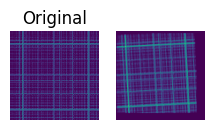

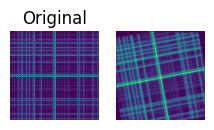

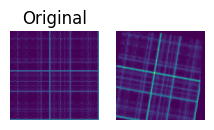

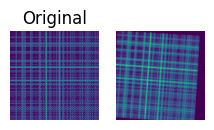

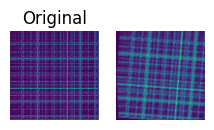

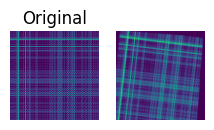

In [41]:
# augment by affine transformations
aug_images = []
for i,path in enumerate(neg_imgs):
    # read image
    img = mpimg.imread(path)
    # append original image
    aug_images.append(img)
    # apply random transformations for 5 times
    for j in range(1):
        # transform
        trans_img = affine_transform(img, 30, 2, 5)
        # append to list
        aug_images.append(trans_img)
    if i%10 == 0:
        plt.figure(figsize=(8,4))
        plt.subplot(1,6,1)
        plt.imshow(img)
        plt.axis('off')
        plt.title('Original')
        for k in range(2,3):
            plt.subplot(1,6,k)
            plt.imshow(aug_images[-1*(k-1)])
            plt.axis('off')
        plt.show()
        plt.close()

In [61]:
for i, img in enumerate(aug_images):
    pil_img = Image.fromarray(img, mode='L')  # 'L' mode for grayscale
    new_path = os.path.join(path, str(i) + '.jpg')
    pil_img.save(new_path)

## OpenCV

In [64]:
# Specify the parameters for our HOG descriptor
win_size = (128, 128)
cell_size = (2, 2)
block_size = (2, 2)
block_stride = (1, 1)
num_bins = 18

# Set the parameters of the HOG descriptor using the variables defined above
hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, num_bins)

In [77]:
# Initialize variables
img_folder_1 = 'C:\\Users\\aless\\Desktop\\opencv competition\\imgs\\healthy'
img_folder_2 = 'C:\\Users\\aless\\Desktop\\opencv competition\\imgs\\pathological'

imgs = []
labels = []

# Process images in folder 1
for img_name in os.listdir(img_folder_1):
    img_path = os.path.join(img_folder_1, img_name)
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))
    if img is not None:
        img = hog.compute(img)
        imgs.append(img)
        labels.append(0)

# Process images in folder 2
for img_name in os.listdir(img_folder_2):
    img_path = os.path.join(img_folder_2, img_name)
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))
    if img is not None:
        img = hog.compute(img)
        imgs.append(img)
        labels.append(1)

# Convert the lists to NumPy arrays
imgs = np.array(imgs)
labels = np.array(labels)

# Print the shape of the arrays to verify
print("Images shape:", imgs.shape)
print("Labels shape:", labels.shape)

Images shape: (318, 290322)
Labels shape: (318,)


There are 208 images from which a vector of features of size 276,768 has been extracted. Labels instead remains the same.

## Training

Here, I scale the features in range [0, 1]

In [78]:
scaler = MinMaxScaler()
x = scaler.fit_transform(imgs)

In [67]:
dump(scaler, 'C:/Users/aless/Desktop/opencv competition/scaler2.joblib')

['C:/Users/aless/Desktop/opencv competition/scaler2.joblib']

In [79]:
clf = SVC(random_state=46, kernel='linear', gamma = 0.0)
cv = StratifiedKFold(shuffle=True, random_state=42)
param_grid = [{'C': [0.0001, 0.001, 0.01, 1, 10, 100]}]
search = HalvingGridSearchCV(clf, param_grid, cv = cv, random_state=42, scoring = 'f1', verbose=3, refit=True).fit(x, labels)
print(search.best_params_)
print(search.best_score_) 

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 106
max_resources_: 318
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 6
n_resources: 106
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ......C=0.0001;, score=(train=1.000, test=0.500) total time=   4.7s
[CV 2/5] END ......C=0.0001;, score=(train=1.000, test=0.308) total time=   3.4s
[CV 3/5] END ......C=0.0001;, score=(train=1.000, test=0.818) total time=   2.9s
[CV 4/5] END ......C=0.0001;, score=(train=1.000, test=0.632) total time=   3.1s
[CV 5/5] END ......C=0.0001;, score=(train=1.000, test=0.500) total time=   3.0s
[CV 1/5] END .......C=0.001;, score=(train=1.000, test=0.500) total time=   3.0s
[CV 2/5] END .......C=0.001;, score=(train=1.000, test=0.308) total time=   3.0s
[CV 3/5] END .......C=0.001;, score=(train=1.000, test=0.818) total time=   3.0s
[CV 4/5] END .......C=0.001;, score=(train=1.000, test=0.632) total time=   3.1s
[CV 5/5] END 

Support Vector Classifier with linear kernel and regularization of strength 10 produced 86.43% of F1 with 5 fold cross-validation technique.

In [82]:
clf = search.best_estimator_
y_pred = cross_val_predict(clf, x, labels, cv=cv)
print(classification_report(labels, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87       165
           1       0.85      0.88      0.86       153

    accuracy                           0.87       318
   macro avg       0.87      0.87      0.87       318
weighted avg       0.87      0.87      0.87       318



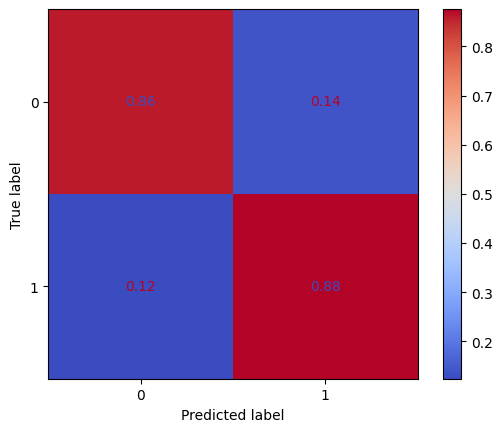

In [84]:
ConfusionMatrixDisplay.from_predictions(labels, y_pred, cmap='coolwarm', normalize = 'true')
plt.show()

In particular, there are more Type-I error than Type-II error, which is an optimal result. In the code below I saved the trained model.

In [85]:
dump(clf, 'C:/Users/aless/Desktop/opencv competition/clf.joblib') 

['C:/Users/aless/Desktop/opencv competition/clf.joblib']